In [26]:
from compute import Var, Par, Model, adda, addf, ureg, Evaluable, buildidpvars
from compute import RefNode, SolverNode, addsolver, geteqs, INTER
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
from inputresolver import getallvars, invert_edges, resolve, reassign, flatten_order
from representations import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm
from representations import render_tree, digraph_repr, drawfull, draw, tree_incidence
from operators import merge_pure
from anytree import LevelOrderIter
from notation import generate_execution, graphs_from_incidence, make_acyclic, default_sequence
from datastructures import notation_from_tree, all_vars_from_incidence
from compute_utils import get_outputs, check_eqs, print_out
from partitioner import default_out_condensation, merge
from pprint import pprint
from anytree import PreOrderIter
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om
import gpkit as gp
import cvxpy as cp
import matplotlib.pyplot as plt

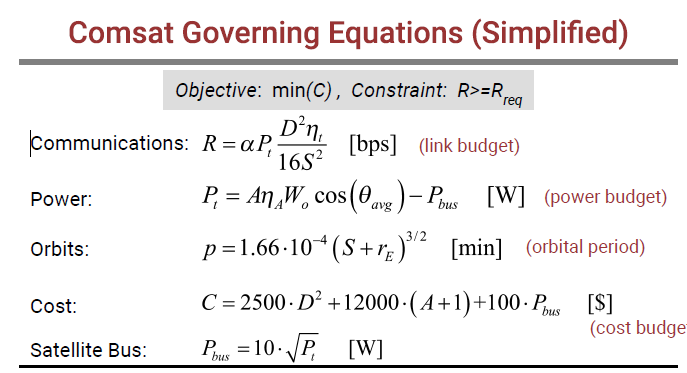

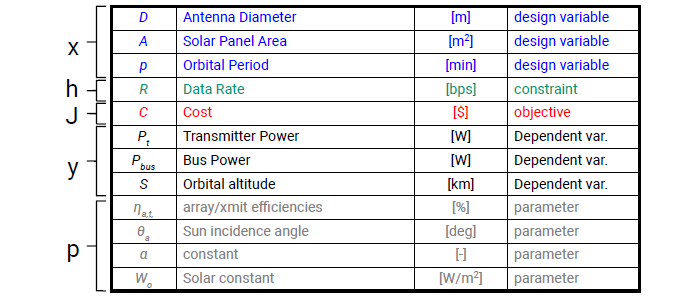

In [2]:
ureg.define('USD = [currency] ')

In [55]:
model = Model()
m = RefNode(name='/', ref=model)
P_t = Var('P_t', unit='W')
Pbus = Var('P_b', unit='W')
S = Var('S', 400, unit='km')
D = Var('D', 0.1, unit='m')
A = Var('A', 0.5, unit='m^2')
eta_t = Par('eta', 0.5)
eta_a = Par('eta', 0.3)
alpha = Par('alpha', 1e20, 'bits/W')
th = Par('theta_a', np.pi/4)
W0 = Par('W_0', 1367, 'W/m^2')
Re = Par('Re', 6378, 'km')
μ = Par('mu', 3.986005e14, 'm^3/s^2')
c1 = Par('c1', 2500, 'USD/m^2')
c2 = Par('c2', 12000, 'USD/m^2')
c3 = Par('c3', 100, 'USD/W')
c4 = Par('c4', 12000, 'USD')
Rreq = Par('R_r', 2, 'MB')
p = adda(m, 'p', 2*np.pi*((S+Re)**3/μ)**0.5, unit='min', returnfx=True)
C = adda(m, 'C', c1*D**2+c2*A+c3*Pbus+c4, returnfx=True)
adda(m, Pbus, P_t)
_, f4 = adda(m, P_t, A*eta_a*W0*sp.cos(th)-Pbus, returnfx=True)
R, f5 = adda(m, 'R', alpha*P_t*D**2*eta_t/(16*S**2), unit='MB', returnfx=True)
r6 = addf(m, R-10);

In [56]:
s1 = addsolver(m, [elt for elt in PreOrderIter(m) if elt.node_type==INTER], [(r6, A)])

## Simpler model

In [57]:
model_optinc = Model()
m2 = RefNode(name='/', ref=model_optinc)
p = adda(m2, 'p', 2*np.pi*((S+Re)**3/μ)**0.5, unit='min', returnfx=True)
C = adda(m2, 'C', c1*D**2+c2*A+c3*Pbus+c4, returnfx=True)
adda(m2, Pbus, P_t)
left,right = model.eqs[f4]
adda(m2, A, sp.simplify(reassigneq(left, right, A)))
left,right = model.eqs[f5]
adda(m2, P_t, sp.simplify(reassigneq(left, right, P_t)))
adda(m2, R, sp.simplify(reassigneq(None, R-10, R)))

# Get order

In [58]:
G, graphs = graphs_from_incidence(m, from_root=True)
m_order = make_acyclic(m, graphs)

In [59]:
G, graphs = graphs_from_incidence(m2, from_root=True)
m_order2 = make_acyclic(m2, graphs)

In [60]:
render_tree(m_order, display_type=True)

/               
└── ., SOLVER   
    ├── f_{0}, INTER
    ├── ., SOLVER
    │   ├── f_{2}, END
    │   └── f_{3}, END
    ├── f_{1}, INTER
    ├── f_{4}, INTER
    └── r_{5}, END


In [61]:
eqs, eqv, dout, dins = model.data_structures()
_, eqv_optinc, _, _ = model_optinc.data_structures()

In [64]:
circular_m = default_sequence(m)
sequence_m = default_sequence(m_order)
sequence_m2 = default_sequence(m_order2)

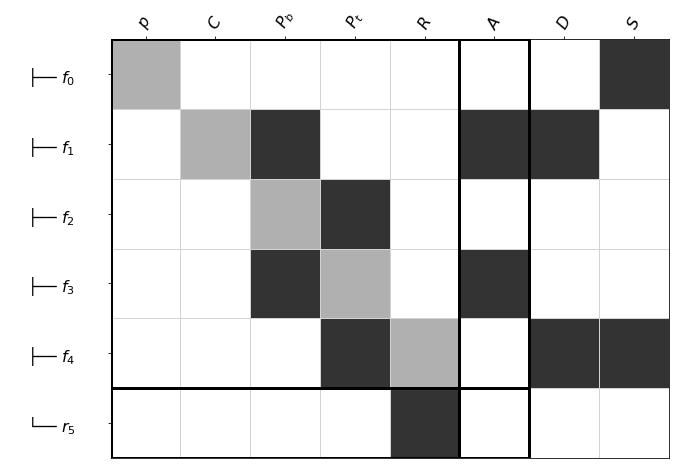

In [65]:
fig, ax = tree_incidence(m, eqv, model.outset, circular_m, figsize=(10,10));
plt.sca(ax)
plt.savefig('figures/minisat_circular.png', dpi=600, bbox_inches='tight')

In [10]:
order = mdf_order(eqv, dout)

In [12]:
eqv_noparams = {elt:{key for key in keys if not key.always_input} for elt,keys in eqv.items()}
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

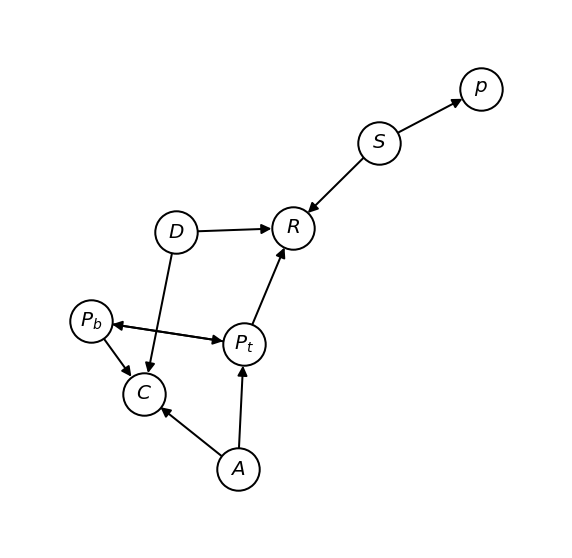

In [15]:
draw(DG, figsize=(10,10), node_shape='o', prog='neato', node_size=1800);

In [11]:
order

[3, (0, 1), 4, 2]

In [31]:
newins = (dins-{A}).union({Rreq})

In [33]:
newins

{D, R_r, Re, S, W_0, alpha, c1, c2, c3, c4, eta, mu, theta_a}

In [59]:
prob = om.Problem()
model = prob.model
dins = default_in(eqs)
buildidpvars(newins, model)
bal = model.add_subsystem('res', om.BalanceComp(), promotes=['A'])
bal.add_balance('A')
model.connect('R', 'res.rhs:A')
model.connect('R_r', 'res.lhs:A')
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.DirectSolver()
counter = coupled_run(eqs, order, (), model, model)
model.group1.group2.nonlinear_solver = om.NonlinearBlockGS()
prob.setup()
prob.set_solver_print(level=1)
prob.run_model()

NL: Newton Converged in 4 iterations


In [60]:
om.n2(prob)

In [58]:
model.list_outputs();

18 Explicit Output(s) in 'model'

varname    val             
---------  ----------------
inp
  mu       [3.986005e+14]  
  c2       [12000.]        
  D        [0.1]           
  c3       [100.]          
  theta_a  [0.78539816]    
  R_r      [2.]            
  W_0      [1367.]         
  c1       [2500.]         
  eta      [0.5]           
  S        [400.]          
  c4       [12000.]        
  alpha    [1.e+20]        
  Re       [6378.]         
group1
  group2
    eq4
      P_b  [81.92]         
    eq1
      P_t  [81.92]         
  eq3
    C      [24284.96927682]
  eq2
    p      [92.55759153]   
  eq0
    R      [2.]            


1 Implicit Output(s) in 'model'

varname  val         
-------  ------------
res
  A      [0.33899744]




In [10]:
vrs =getallvars(eqs)

In [11]:
vrs

{A, C, D, P_b, P_t, R, S, p}

In [12]:
order

[(1, 4), 2, 3, 0]

In [16]:
B, edges = bipartite_repr(eqv)

In [19]:
newdout = resolve(eqs, vrs, invert_edges(edges), maxiter=1, not_input=None)

C []
1 0.0 []


In [20]:
newdout

[(0, P_t), (1, A), (2, S), (3, C), (4, P_b)]